### Exercise
1. Read the dataset, standardize and check if the dataset is balanced. Moreover, check if the dataset requires other preprocessing activities such as missing data imputation and handling of categorial variables
2. Split the dataset in training data (75%) and test data (25%)
3. Perform tuning of the two techniques using the grid search method
4. Apply the best configuration of the two learning techniques on the test data
5. Evalutate the performance by using the accuracy, the precision, the recall, the f1-score and the ROC curve

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,f1_score,confusion_matrix,roc_curve,auc,precision_score,recall_score,accuracy_score

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data',header=None)
X = df.loc[: , 2:].values
y = df.loc[:, 1].values
le = LabelEncoder()
y = le.fit_transform(y)
np.bincount(y)

array([357, 212], dtype=int64)

In [2]:
X_train , X_test , y_train , y_test = train_test_split(X,
                                        y, 
                                        test_size=0.25, 
                                        stratify=y, 
                                        random_state=1)

## SVC Classifier 

In [7]:
param_range = [0.001 , 0.01 , 0.1 , 1.0 , 10.0 , 100.0 , 1000.0]
degree=[2,3,4,5,6,7]

pipe_svm = make_pipeline(StandardScaler(), 
            SVC(random_state=1, probability=True))

param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                {'svc__C': param_range,'svc__gamma': param_range,'svc__kernel': ['rbf']}, 
                {'svc__C': param_range , 'svc__degree': degree , 'svc__kernel':['poly']}]

scorer=make_scorer(f1_score)

gs = GridSearchCV(estimator=pipe_svm, 
        param_grid=param_grid, 
        scoring=scorer, 
        n_jobs=-1, 
        refit=True, 
        cv=10)

gs=gs.fit(X_train , y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9808467741935484
{'svc__C': 1.0, 'svc__kernel': 'linear'}


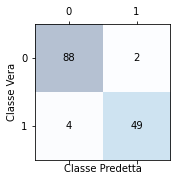

In [8]:
y_pred = gs.predict(X_test)
confmat = confusion_matrix(y_true=y_test,
            y_pred=y_pred)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,
    cmap=plt.cm.Blues,
    alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,
            y=i,
            s=confmat[i,j],
            va='center',
            ha='center',)
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Vera')
plt.show()

In [9]:
print('Precision: %.3f' % precision_score( y_true =y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true =y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true =y_test, y_pred=y_pred))
print('Accuracy: %.3f' % accuracy_score(y_true =y_test, y_pred=y_pred))

Precision: 0.961
Recall: 0.925
F1: 0.942
Accuracy: 0.958


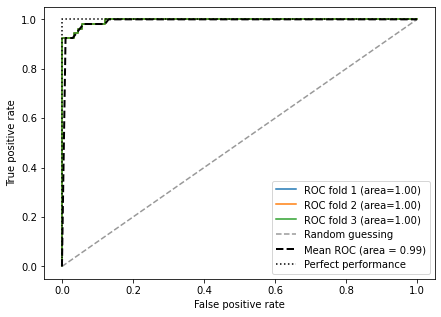

In [10]:
cv1 = list(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X_train, y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv1):
    probas=pipe_svm.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve (y_test, probas[:, 1], pos_label=1)
    mean_tpr += np.interp (mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area=%0.2f)" %(i+1, roc_auc))
plt.plot([0, 1],[0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr/=len(cv1)
mean_tpr[-1] = 1.0
mean_auc =auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()

## Random Forest Classifier

In [11]:
n_estimators = [10 , 50 , 100]
max_depth=[10 , 100 , 200]

pipe_forest = make_pipeline(RandomForestClassifier(random_state=1))

param_grid_tree = [{'randomforestclassifier__n_estimators': n_estimators, 'randomforestclassifier__criterion': ['gini'] , 'randomforestclassifier__max_depth': max_depth},
            {'randomforestclassifier__n_estimators': n_estimators, 'randomforestclassifier__criterion': ['entropy'] , 'randomforestclassifier__max_depth': max_depth}]
                
gs_t = GridSearchCV(estimator=pipe_forest, 
        param_grid=param_grid_tree, 
        scoring=scorer, 
        n_jobs=-1, 
        refit=True, 
        cv=10)

gs_t=gs_t.fit(X_train , y_train)
print(gs_t.best_score_)
print(gs_t.best_params_)

0.9517680840664713
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}


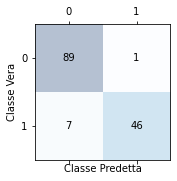

In [12]:
y_pred_t = gs_t.predict(X_test)
confmat = confusion_matrix(y_true=y_test,
            y_pred=y_pred_t)
fig,ax=plt.subplots(figsize=(2.5,2.5))
ax.matshow(confmat,
    cmap=plt.cm.Blues,
    alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j,
            y=i,
            s=confmat[i,j],
            va='center',
            ha='center',)
plt.xlabel('Classe Predetta')
plt.ylabel('Classe Vera')
plt.show()

In [13]:
print('Precision: %.3f' % precision_score( y_true =y_test, y_pred=y_pred_t))
print('Recall: %.3f' % recall_score(y_true =y_test, y_pred=y_pred_t))
print('F1: %.3f' % f1_score(y_true =y_test, y_pred=y_pred_t))
print('Accuracy: %.3f' % accuracy_score(y_true =y_test, y_pred=y_pred_t))

Precision: 0.979
Recall: 0.868
F1: 0.920
Accuracy: 0.944


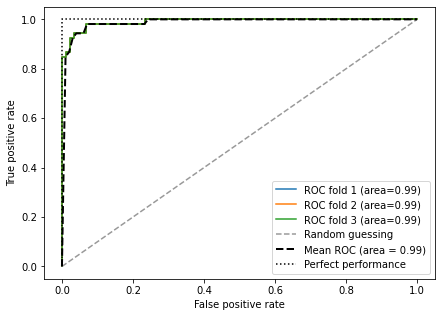

In [14]:
cv1 = list(StratifiedKFold(n_splits=3, random_state=1, shuffle=True).split(X_train, y_train))
fig=plt.figure(figsize=(7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate (cv1):
    probas=pipe_forest.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve (y_test, probas[:, 1], pos_label=1)
    mean_tpr += np.interp (mean_fpr, fpr, tpr)
    mean_tpr[0]=0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label="ROC fold %d (area=%0.2f)" %(i+1, roc_auc))
plt.plot([0, 1],[0, 1], linestyle="--", color=(0.6, 0.6, 0.6), label="Random guessing")
mean_tpr/=len(cv1)
mean_tpr[-1] = 1.0
mean_auc =auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, "k--", label="Mean ROC (area = %0.2f)" % mean_auc, lw=2)
plt.plot([0, 0, 1], [0, 1, 1], linestyle=":", color="black", label="Perfect performance")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc="lower right")
plt.show()